# Capstone Project - The Battle of the Neighborhoods
###  Veterinary Clinic in Madrid, Spain
#### Applied Data Science Capstone by IBM/Coursera

## Introduction: Business Problem

For a veterinarian who decides to open a new veterinarian clinic in Madrid, Spain it is very important to know the distribution of pets and veterinarian clinics in the neighbourhoods of Madrid to find an optimal location for the new facility.

We will analyze the number of pets per neighborhood and the number of veterinarians to detect those neighborhoods with the highest ratios of pets per veterinarian (i.e. with more needing of locating a new facility).

On the other hand, it is also important to check the ascending trend of the number of pets in Madrid in the last five years and analyze those boroughs with highest increase ratios.

With these two criteria we will cluster the neighbourhoods to detect the most promising neighborhoods to install a new veterinary clinic (and the most "saturated" neighbourhood to avoid). 

## Data

Based on the definition of the problem, factors that will influence our decission are:

- increase in the number of pets in the last 5 years
- number of pets in the neighbourhood,
- number of veterinary clinics in the neighbourhood
   

Following data sources will be needed to extract/generate the required information:

- name and location of the boroughs and neighbourhoods of Madrid: City Hall Public Data web publishes the street guide including numbering of all urban premises (206866 premises). We will extract the name of the boroughs, neighbourhoods and their location.

- number of pets in the last five years: City Hall Public Data web publishes the number of dogs and cats per borough in the last 5 years. We will extract the increase of the number of total pets per borough. On the other hand, since the number of pets is published per borough, we use the proportion of population to distribute the number of pets per neighbourhood.

- number of veterinary in every neighborhood: City Hall Public Data web publishes the active venues in Madrid (163251 venues). We will extract the number of veterinary clinics per neighbourhood.

(Note:I have decided not to use the Foursquare API since not so much venues are registered in application yet. A checking of this is included in the code)

As final dataframe we will have per each neighbourhood:
- Borough
- Location: Latitude and Longitude
- Total Number of pets
- Increase of the number of pets in the last 5 years
- Number of veterinarian clinics
- Ratio pets/vet


In [1]:
# The code was removed by Watson Studio for sharing.

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')


Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


## 1. Download and Explore Dataset - Map of Neighbourhoods

The City Hall of Madrid Web publishes a big amount of public data of the city.

Data Source: City Hall Public Data web https://datos.madrid.es/portal/site/egob


In [3]:
# From the street directoty of the city, it is extracted the list of boroughs, neighbourhoods and location
df=pd.read_csv(project.get_file('CALLEJERO_VIGENTE_NUMERACIONES_201908.csv'), sep=';', encoding = "ISO-8859-1")
df.head(5)

,Codigo de numero,Codigo de via,Clase de la via,Partícula de la vía,Nombre de la vía,Literal de numeracion,Codigo de distrito,Nombre del distrito,Codigo de barrio,Nombre del barrio,Seccion censal,Codigo postal,Seccion de carteria,Zona Servicio Estacionamiento Regulado,Categoria fiscal,Direccion completa para el numero,Coordenada X (Guia Urbana) cm,Coordenada Y (Guia Urbana) cm,Longitud en S R ETRS89 WGS84,Latitud en S R ETRS89 WGS84,Tipo de la via a la que pertenece el numero,Situacion de la via respecto al terreno,Tipo de denominacion de la via,Parcela catastral del numero,Tipologia del numero,Zona de valor del numero
0,31031089,31001337,AUTOVIA,,A-1,KM.001000EN,8,FUENCARRAL-EL PARDO,6,VALVERDE,166,28050,ND,0,9,"AUTOV A-1, 001000 EN ...",44305633,448250340,3º40'23.6'' W,40º29'21.82'' N,Topónimo,Nivel,Admon,,Parcela,R21S
1,31031088,31001337,AUTOVIA,,A-1,KM.001000SA,16,HORTALEZA,6,VALDEFUENTES,119,28050,ND,0,9,"AUTOV A-1, 001000 SA ...",44312246,448249077,3º40'20.75'' W,40º29'21.45'' N,Topónimo,Nivel,Admon,,Parcela,R21N
2,31031091,31001337,AUTOVIA,,A-1,KM.001100EN,8,FUENCARRAL-EL PARDO,6,VALVERDE,171,28050,ND,0,9,"AUTOV A-1, 001100 EN ...",44367522,448330933,3º39'57.57'' W,40º29'48.11'' N,Topónimo,Nivel,Admon,,Parcela,R21S
3,31031090,31001337,AUTOVIA,,A-1,KM.001100SA,16,HORTALEZA,6,VALDEFUENTES,125,28050,ND,0,9,"AUTOV A-1, 001100 SA ...",44373755,448325151,3º39'54.87'' W,40º29'46.28'' N,Topónimo,Nivel,Admon,,Parcela,R21R
4,31031093,31001337,AUTOVIA,,A-1,KM.001200EN,8,FUENCARRAL-EL PARDO,6,VALVERDE,167,28050,ND,0,9,"AUTOV A-1, 001200 EN ...",44425207,448408185,3º39'33.3'' W,40º30'13.32'' N,Topónimo,Nivel,Admon,,Parcela,R21O


In [4]:
# it is a very big dataframe
df.shape

(206866, 26)

In [5]:
# Only the 6 columns required are selected
names = list(df.columns)
names[6]='Borough Code'
names[7]='Borough'
names[8]='Neighbourhood Code'
names[9]='Neighbourhood'
names[18] = 'Longitude'
names[19] = 'Latitude'
df.columns = names
df=df[['Borough Code','Borough','Neighbourhood Code','Neighbourhood','Longitude','Latitude']]
df.head()

,Borough Code,Borough,Neighbourhood Code,Neighbourhood,Longitude,Latitude
0,8,FUENCARRAL-EL PARDO,6,VALVERDE,3º40'23.6'' W,40º29'21.82'' N
1,16,HORTALEZA,6,VALDEFUENTES,3º40'20.75'' W,40º29'21.45'' N
2,8,FUENCARRAL-EL PARDO,6,VALVERDE,3º39'57.57'' W,40º29'48.11'' N
3,16,HORTALEZA,6,VALDEFUENTES,3º39'54.87'' W,40º29'46.28'' N
4,8,FUENCARRAL-EL PARDO,6,VALVERDE,3º39'33.3'' W,40º30'13.32'' N


In [6]:
# table index for the borough codes is created to be used later
codigos_distrito=df[['Borough Code','Borough']].drop_duplicates().sort_values(['Borough Code'])
codigos_distrito=codigos_distrito.reset_index(drop=True)
codigos_distrito

,Borough Code,Borough
0,1,CENTRO
1,2,ARGANZUELA
2,3,RETIRO
3,4,SALAMANCA
4,5,CHAMARTIN
5,6,TETUAN
6,7,CHAMBERI
7,8,FUENCARRAL-EL PARDO
8,9,MONCLOA-ARAVACA
9,10,LATINA


In [7]:
#coordinates transforming function definition
def latDD(x): 
    D = int(x[:x.find('º')]) 
    M = int(x[x.find('º')+1:x.find("'")]) 
    S = float(x[x.find("'")+1:x.find("''")]) 
    DD = D + float(M)/60 + float(S)/3600
    return DD

def lonDD(x): 
    D = int(x[:x.find('º')]) 
    M = int(x[x.find('º')+1:x.find("'")]) 
    S = float(x[x.find("'")+1:x.find("''")]) 
    DD = -(D + float(M)/60 + float(S)/3600)
    return DD

In [8]:
#coordinates transforming function aplication
columnas=list(df.columns)
df['Longitude']=df['Longitude'].apply(lonDD)
df['Latitude']=df['Latitude'].apply(latDD)
df.head()

,Borough Code,Borough,Neighbourhood Code,Neighbourhood,Longitude,Latitude
0,8,FUENCARRAL-EL PARDO,6,VALVERDE,-3.673222,40.489394
1,16,HORTALEZA,6,VALDEFUENTES,-3.672431,40.489292
2,8,FUENCARRAL-EL PARDO,6,VALVERDE,-3.665992,40.496697
3,16,HORTALEZA,6,VALDEFUENTES,-3.665242,40.496189
4,8,FUENCARRAL-EL PARDO,6,VALVERDE,-3.659250,40.503700


In [9]:
#grouping by neighbourhood and reordering columns
df=df.groupby(['Neighbourhood']).mean()
df=df.reset_index()
df=df.join(codigos_distrito.set_index('Borough Code'), on='Borough Code')
columnas=df.columns.tolist()
columnas= columnas[1:2] + columnas[-1:]+ columnas[2:3]+columnas[0:1]+columnas[3:5]
df=df[columnas]
df=df.sort_values(['Borough Code', 'Neighbourhood Code'])
df=df.reset_index(drop=True)
df

,Borough Code,Borough,Neighbourhood Code,Neighbourhood,Longitude,Latitude
0,1,CENTRO,1,PALACIO,-3.711270,40.414430
1,1,CENTRO,2,EMBAJADORES,-3.702885,40.409738
2,1,CENTRO,3,CORTES,-3.697530,40.414064
3,1,CENTRO,4,JUSTICIA,-3.697507,40.423651
4,1,CENTRO,5,UNIVERSIDAD,-3.706039,40.425119
5,1,CENTRO,6,SOL,-3.704920,40.416991
6,2,ARGANZUELA,1,IMPERIAL,-3.718203,40.407663
7,2,ARGANZUELA,2,ACACIAS,-3.706246,40.401900
8,2,ARGANZUELA,3,CHOPERA,-3.698228,40.395881
9,2,ARGANZUELA,4,LEGAZPI,-3.689785,40.388806


In [10]:
# calculate number of boroughs and neighbourhoods
print('Madrid has {} boroughs and {} neighbourhoods.'.format(
        len(df['Borough'].unique()),
        df.shape[0]
    )
)

Madrid has 21 boroughs and 131 neighbourhoods.


### Map of Madrid Neighbourhoods

In [11]:
address = 'Madrid'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Madrid are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Madrid are 40.4167047, -3.7035825.


In [50]:
# create map of Madrid using latitude and longitude values
map_madrid = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighbourhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_madrid)  
    
map_madrid

## 2. Explore Neighbourhoods in Madrid - via FourSquare

Analisys of data fron Madrid obtained form FourSquare application

In [13]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

CLIENT_ID = 'I2JEH30YZ5DWC4DQBZAY05XPA3QR3JLCGB0KDB4B34B3XEXM' # your Foursquare ID
CLIENT_SECRET = 'IQJUV2X3DXB0E0EQ4VE4TCNHTIEGZ3O5OQ2S5I2RHAGXIMVG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: I2JEH30YZ5DWC4DQBZAY05XPA3QR3JLCGB0KDB4B34B3XEXM
CLIENT_SECRET:IQJUV2X3DXB0E0EQ4VE4TCNHTIEGZ3O5OQ2S5I2RHAGXIMVG


In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
madrid_venues = getNearbyVenues(names=df['Neighbourhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )


PALACIO             
EMBAJADORES         
CORTES              
JUSTICIA            
UNIVERSIDAD         
SOL                 
IMPERIAL            
ACACIAS             
CHOPERA             
LEGAZPI             
DELICIAS            
PALOS DE MOGUER     
ATOCHA              
PACIFICO            
ADELFAS             
ESTRELLA            
IBIZA               
LOS JERONIMOS       
NIÑO JESUS          
RECOLETOS           
GOYA                
FUENTE DEL BERRO    
GUINDALERA          
LISTA               
CASTELLANA          
EL VISO             
PROSPERIDAD         
CIUDAD JARDIN       
HISPANOAMERICA      
NUEVA ESPAÑA        
CASTILLA            
BELLAS VISTAS       
CUATRO CAMINOS      
CASTILLEJOS         
ALMENARA            
VALDEACEDERAS       
BERRUGUETE          
GAZTAMBIDE          
ARAPILES            
TRAFALGAR           
ALMAGRO             
RIOS ROSAS          
VALLEHERMOSO        
EL PARDO            
FUENTELARREINA      
PEÑA GRANDE         
EL PILAR            
LA PAZ       

In [16]:
print(madrid_venues.shape)
madrid_venues.head()

(3593, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,PALACIO,40.41443,-3.71127,Plaza de la Villa,40.415409,-3.710391,Historic Site
1,PALACIO,40.41443,-3.71127,Cervecería La Mayor,40.415218,-3.712194,Beer Bar
2,PALACIO,40.41443,-3.71127,Mercado de San Miguel,40.415443,-3.708943,Market
3,PALACIO,40.41443,-3.71127,Mercado Jamón Iberico,40.415309,-3.711633,Market
4,PALACIO,40.41443,-3.71127,Pinkleton & Wine,40.415390,-3.709050,Wine Bar


In [17]:
print('Foursquare application has {} registered venues in Madrid.'.format(
        madrid_venues.shape[0]
    )
)

Foursquare application has 3593 registered venues in Madrid.


In [18]:
# Musseum del Prado is one of the most important venues in the city of Madrid and one of the most important
# picture musseum in the world. Lets check if Musseum del Prado is included in the venues od Madrid
madrid_venues[madrid_venues['Venue']=='%Prado']

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category


In [19]:
madrid_venues[madrid_venues['Venue Category']=='Museum']

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
211,CORTES,40.414064,-3.697530,Casa Museo Lope de Vega,40.414326,-3.697468,Museum
335,JUSTICIA,40.423651,-3.697507,Museo del Romanticismo,40.425802,-3.698850,Museum
753,DELICIAS,40.396839,-3.691106,Museo del Ferrocarril (Antigua Estación de Del...,40.399395,-3.692286,Museum
810,PALOS DE MOGUER,40.403352,-3.694550,Museo del Ferrocarril (Antigua Estación de Del...,40.399395,-3.692286,Museum
911,PACIFICO,40.404516,-3.677749,Nave de Motores Metro de Madrid,40.404325,-3.673934,Museum
912,PACIFICO,40.404516,-3.677749,Real Fábrica de Tapices,40.406202,-3.682074,Museum
973,ADELFAS,40.401066,-3.671138,Nave de Motores Metro de Madrid,40.404325,-3.673934,Museum
1085,LOS JERONIMOS,40.412922,-3.687449,Real Observatorio de Madrid,40.409381,-3.688168,Museum
1362,FUENTE DEL BERRO,40.424888,-3.664744,Museo Casa de la Moneda,40.422830,-3.668966,Museum
1936,CUATRO CAMINOS,40.451556,-3.699126,Museo Tiflológico,40.455398,-3.700755,Museum


The total number of museums in the city of Madrid according to the City Council is around 70 (away from the 10 FourSquares records) that include, of course, the Prado Museum, the Thyssen-Bornemisza Museum, the Reina Sofía Museum, etc. . It is for this reason, that I consider that the FourSquare application does not yet have enough records for the city of Madrid. For the rest of the Capstone I will use the City Hall Public data web of Madrid. 

## 3. Explore Neighbourhoods in Madrid - via City Hall Public Data

Data Source: City Hall Public Data web https://datos.madrid.es/portal/site/egob

As we are interesting in installing a new veterinary clinic, we analyse first the increase of the number of pets.

In [20]:
# In the file "Censo animales.csv" we have the total number of pets per Borough and the increase in the last 5 years
pets=pd.read_csv(project.get_file('Censo animales .csv'), sep=';', encoding = "ISO-8859-1")
names = list(pets.columns)
names[0]='Year'
names[1]='Borough_code'
names[2]='Borough'
names[3]='Dogs'
names[4]='Cats'
pets.columns = names
pets['Total_pets']=pets['Dogs']+pets['Cats']

pets.head(30)


,Year,Borough_code,Borough,Dogs,Cats,Total_pets
0,2018,2,ARGANZUELA,10622,4458,15080
1,2018,21,BARAJAS,5203,1300,6503
2,2018,11,CARABANCHEL,20265,5524,25789
3,2018,1,CENTRO,15881,8186,24067
4,2018,5,CHAMARTÍN,11417,3601,15018
5,2018,7,CHAMBERÍ,13615,4087,17702
6,2018,15,CIUDAD LINEAL,17375,7226,24601
7,2018,8,FUENCARRAL-EL PARDO,17645,5558,23203
8,2018,16,HORTALEZA,15965,7797,23762
9,2018,10,LATINA,19282,7990,27272


In [21]:
#pivot table to analyse the number of pets per borough and year
pets=pets.pivot_table('Total_pets',['Borough_code','Borough'],'Year')
pets=pets.rename_axis(None, axis=1).reset_index()

# calculation of the increase in the number of pets per borough in the last five years
pets['Inc_5_y (%)']=(pets[2018]/pets[2014]-1)*100
pets=pets.round({'Inc_5_y (%)': 1})


pets

,Borough_code,Borough,2014,2015,2016,2017,2018,Inc_5_y (%)
0,1,CENTRO,16745,17045,21634,22527,24067,43.7
1,2,ARGANZUELA,11448,11728,13793,14476,15080,31.7
2,3,RETIRO,10118,10274,10244,10622,10728,6.0
3,4,SALAMANCA,14735,15019,16133,17002,17832,21.0
4,5,CHAMARTÍN,14735,15019,14568,15017,15018,1.9
5,6,TETUÁN,14479,14706,15851,16434,17241,19.1
6,7,CHAMBERÍ,15771,16115,16440,17228,17702,12.2
7,8,FUENCARRAL-EL PARDO,20823,21124,22259,23062,23203,11.4
8,9,MONCLOA-ARAVACA,13946,14270,14968,15514,15915,14.1
9,10,LATINA,20639,21124,22297,23606,27272,32.1


In [22]:
# select only required columns
pets=pets[['Borough_code','Borough',2018,'Inc_5_y (%)']]
names=list(pets.columns)
names[2]='Total_pets'
pets.columns = names
pets


,Borough_code,Borough,Total_pets,Inc_5_y (%)
0,1,CENTRO,24067,43.7
1,2,ARGANZUELA,15080,31.7
2,3,RETIRO,10728,6.0
3,4,SALAMANCA,17832,21.0
4,5,CHAMARTÍN,15018,1.9
5,6,TETUÁN,17241,19.1
6,7,CHAMBERÍ,17702,12.2
7,8,FUENCARRAL-EL PARDO,23203,11.4
8,9,MONCLOA-ARAVACA,15915,14.1
9,10,LATINA,27272,32.1


In [23]:
print('There are {} registered pets in Madrid.'.format(
        pets['Total_pets'].sum()
    )
)

print('The increase of the number of pets in the last 5 years in Madrid is {}%.'.format(
        round(pets['Inc_5_y (%)'].mean(),1)
    )
)

There are 370018 registered pets in Madrid.
The increase of the number of pets in the last 5 years in Madrid is 22.0%.


In [24]:
# as we have the number of pets per borough, we use the proportion of population to distribute the number of pets
# per neighbourhood. First we download the population file from the City Hall Public web
population=pd.read_csv(project.get_file('Rango_Edades_Seccion_201908.csv'), sep=';', encoding = "ISO-8859-1")
names = list(population.columns)
names[0]='Borough_code'
names[1]='Borough'
names[2]='Neighbourhood_code'
names[3]='Neighbourhood'
names[8]='SpanishMen'
names[9]='SpanishWomen'
names[10]='OtherMen'
names[11]='OtherWomen'
population.columns = names
population=population.fillna(0)
population['Total_Pop_Neighbourhood']=population['SpanishMen']+population['SpanishWomen']+population['OtherMen']+population['OtherWomen']
population.head()

,Borough_code,Borough,Neighbourhood_code,Neighbourhood,COD_BARRIO,COD_DIST_SECCION,COD_SECCION,COD_EDAD_INT,SpanishMen,SpanishWomen,OtherMen,OtherWomen,Total_Pop_Neighbourhood
0,1,CENTRO,101,PALACIO,1,1001,1,0,3.0,2.0,0.0,1.0,6.0
1,1,CENTRO,101,PALACIO,1,1001,1,1,3.0,1.0,1.0,2.0,7.0
2,1,CENTRO,101,PALACIO,1,1001,1,2,1.0,1.0,1.0,0.0,3.0
3,1,CENTRO,101,PALACIO,1,1001,1,3,3.0,3.0,1.0,1.0,8.0
4,1,CENTRO,101,PALACIO,1,1001,1,4,2.0,3.0,1.0,1.0,7.0


In [25]:
# the population per neighbourhood
pop_neigh=population.pivot_table('Total_Pop_Neighbourhood',['Borough_code','Borough','Neighbourhood_code','Neighbourhood'],aggfunc='sum')
pop_neigh=pop_neigh.rename_axis(None, axis=1).reset_index()
pop_neigh

,Borough_code,Borough,Neighbourhood_code,Neighbourhood,Total_Pop_Neighbourhood
0,1,CENTRO,101,PALACIO,23428.0
1,1,CENTRO,102,EMBAJADORES,46622.0
2,1,CENTRO,103,CORTES,10727.0
3,1,CENTRO,104,JUSTICIA,17761.0
4,1,CENTRO,105,UNIVERSIDAD,32991.0
5,1,CENTRO,106,SOL,7508.0
6,2,ARGANZUELA,201,IMPERIAL,22907.0
7,2,ARGANZUELA,202,ACACIAS,36958.0
8,2,ARGANZUELA,203,CHOPERA,20208.0
9,2,ARGANZUELA,204,LEGAZPI,19784.0


In [26]:
# the population per borough
pop_bor=population.pivot_table('Total_Pop_Neighbourhood',['Borough_code'],aggfunc='sum')
pop_bor=pop_bor.rename_axis(None, axis=1).reset_index()
pop_bor.rename(columns={'Total_Pop_Neighbourhood': 'Total_Pop_Bor'}, inplace=True)
pop_bor

,Borough_code,Total_Pop_Bor
0,1,139037.0
1,2,155377.0
2,3,120239.0
3,4,147273.0
4,5,147435.0
5,6,160421.0
6,7,140289.0
7,8,249159.0
8,9,120849.0
9,10,241165.0


In [27]:
# pets and population per borough
pets=pets.set_index('Borough_code').join(pop_bor.set_index('Borough_code') )
pets=pets.rename_axis(None, axis=1).reset_index()
pets=pets.drop('Borough',axis=1)
pets

,Borough_code,Total_pets,Inc_5_y (%),Total_Pop_Bor
0,1,24067,43.7,139037.0
1,2,15080,31.7,155377.0
2,3,10728,6.0,120239.0
3,4,17832,21.0,147273.0
4,5,15018,1.9,147435.0
5,6,17241,19.1,160421.0
6,7,17702,12.2,140289.0
7,8,23203,11.4,249159.0
8,9,15915,14.1,120849.0
9,10,27272,32.1,241165.0


In [28]:
# distribution of pets per neighbourhood
pets=pop_neigh.set_index('Borough_code').join(pets.set_index('Borough_code') )
pets=pets.rename_axis(None, axis=1).reset_index()
pets.rename(columns={'Total_pets': 'Total_Pets_Borough'}, inplace=True)
pets['Total_Pets_Neighbourhood']=pets['Total_Pets_Borough']/pets['Total_Pop_Bor']*pets['Total_Pop_Neighbourhood']
pets=pets.round({'Total_Pets_Neighbourhood': 0})
pets=pets.drop('Borough',axis=1)
pets=pets.set_index('Neighbourhood').join(df.set_index('Neighbourhood') )
pets=pets.rename_axis(None, axis=1).reset_index()
pets=pets.iloc[:, [0,9,11,12,7,5]] 

pets

,Neighbourhood,Borough,Longitude,Latitude,Total_Pets_Neighbourhood,Inc_5_y (%)
0,PALACIO,CENTRO,-3.711270,40.414430,4055.0,43.7
1,EMBAJADORES,CENTRO,-3.702885,40.409738,8070.0,43.7
2,CORTES,CENTRO,-3.697530,40.414064,1857.0,43.7
3,JUSTICIA,CENTRO,-3.697507,40.423651,3074.0,43.7
4,UNIVERSIDAD,CENTRO,-3.706039,40.425119,5711.0,43.7
5,SOL,CENTRO,-3.704920,40.416991,1300.0,43.7
6,IMPERIAL,ARGANZUELA,-3.718203,40.407663,2223.0,31.7
7,ACACIAS,ARGANZUELA,-3.706246,40.401900,3587.0,31.7
8,CHOPERA,ARGANZUELA,-3.698228,40.395881,1961.0,31.7
9,LEGAZPI,ARGANZUELA,-3.689785,40.388806,1920.0,31.7


In [29]:
# download venues from the City Hall Data Web
vets=pd.read_csv(project.get_file('OPEN DATA Locales-Epigrafes201907.csv'), sep=';', encoding = "ISO-8859-1", low_memory=False)
vets.head()

,id_local,id_distrito_local,desc_distrito_local,id_barrio_local,desc_barrio_local,cod_barrio_local,id_seccion_censal_local,desc_seccion_censal_local,coordenada_x_local,coordenada_y_local,id_tipo_acceso_local,desc_tipo_acceso_local,id_situacion_local,desc_situacion_local,id_vial_edificio,clase_vial_edificio,desc_vial_edificio,id_ndp_edificio,id_clase_ndp_edificio,nom_edificio,num_edificio,cal_edificio,secuencial_local_PC,id_vial_acceso,clase_vial_acceso,desc_vial_acceso,id_ndp_acceso,id_clase_ndp_acceso,nom_acceso,num_acceso,cal_acceso,coordenada_x_agrupacion,coordenada_y_agrup,id_agrupacion,nombre_agrupacion,id_tipo_agrup,desc_tipo_agrup,id_planta_agrupado,id_local_agrupado,rotulo,id_seccion,desc_seccion,id_division,desc_division,id_epigrafe,desc_epigrafe
0,270315185,20,SAN BLAS-CANILLEJAS,2003,AMPOSTA,NaN,NaN,34,"447255,56","4475268,44",NaN,Puerta Calle,NaN,Abierto,43700,CALLE,AMPOSTA ...,11135325,1,NUM,18,,10,NaN,CALLE,AMPOSTA ...,11135325,1,NUM,18,,NaN,NaN,NaN,NaN,NaN,NaN,PB,NaN,FRUTAS JOSE VERDURAS ...,G,COMERCIO AL POR MAYOR Y AL POR MENOR; REPARACI...,47,"COMERCIO AL POR MENOR, EXCEPTO DE VEHICULOS DE...",472102,COMERCIO AL POR MENOR DE FRUTAS Y HORTALIZAS S...
1,270315223,15,CIUDAD LINEAL,1504,CONCEPCION,NaN,NaN,114,"444279,58","4476078,48",NaN,Agrupado,NaN,Abierto,791400,CALLE,VIRGEN DE LA ALEGRIA ...,20083520,1,NUM,10,,0,NaN,CALLE,VIRGEN DE LA ALEGRIA ...,20083520,1,NUM,10,,"444279,58","4476078,48",99000092.0,MERCADO MUNICIPAL LAS VENTAS,12.0,Mercado Municipal,2,260,BOUTIQUE DE LA CARNE ...,G,COMERCIO AL POR MAYOR Y AL POR MENOR; REPARACI...,47,"COMERCIO AL POR MENOR, EXCEPTO DE VEHICULOS DE...",472201,COMERCIO AL POR MENOR DE CARNICERIA
2,270315300,11,CARABANCHEL,1105,PUERTA BONITA,NaN,NaN,119,0,0,NaN,Puerta Calle,NaN,Baja Reunificacion,433500,CALLE,CAMINO VIEJO DE LEGANES ...,31009367,1,NUM,104,,20,NaN,CALLE,CAMINO VIEJO DE LEGANES ...,31009367,1,NUM,104,,NaN,NaN,NaN,NaN,NaN,NaN,PB,NaN,"FACIL ENVIOS S A, LOCUTORIO",J,INFORMACI0N Y COMUNICACIONES,61,TELECOMUNICACIONES,610002,LOCUTORIOS
3,270315331,21,BARAJAS,2104,TIMON,NaN,NaN,30,"450276,58","4480160,41",NaN,Puerta Calle,NaN,Abierto,6300,CALLE,AERONAVE ...,11141720,1,NUM,13,,10,NaN,CALLE,AERONAVE ...,11141720,1,NUM,13,,NaN,NaN,NaN,NaN,NaN,NaN,PB,NaN,PERFUMERIA,G,COMERCIO AL POR MAYOR Y AL POR MENOR; REPARACI...,47,"COMERCIO AL POR MENOR, EXCEPTO DE VEHICULOS DE...",477501,COMERCIO AL POR MENOR DE ARTICULOS DE PERFUMER...
4,270315335,5,CHAMARTIN,503,CIUDAD JARDIN,NaN,NaN,45,"442828,59","4477599,51",NaN,Puerta Calle,NaN,Abierto,689500,CALLE,SANCHEZ PACHECO ...,11024105,1,NUM,48,,20,NaN,CALLE,SANCHEZ PACHECO ...,11024105,1,NUM,48,,NaN,NaN,NaN,NaN,NaN,NaN,PB,NaN,LU AND CIA,I,HOSTELERIA,56,SERVICIOS DE COMIDAS Y BEBIDAS,561004,BAR RESTAURANTE


In [30]:
vets.shape

(163251, 46)

In [31]:
# counting the veterinary clinic per neighbourhood
vets.rename(columns={'desc_barrio_local': 'Neighbourhood','desc_division': 'Activity' }, inplace=True)
vets=vets[['Neighbourhood','Activity' ]]
vets.head()
vets=vets[vets['Activity'].str.contains("VETERINARIAS")==True] 
vets=vets['Neighbourhood'].value_counts()
vets=pd.DataFrame(vets)
vets=vets.rename_axis(None, axis=1).reset_index()
names = list(vets.columns)
names[0]='Neighbourhood'
names[1]='Number_of_Vets'
vets.columns = names
vets

,Neighbourhood,Number_of_Vets
0,GUINDALERA,13
1,PUEBLO NUEVO,10
2,CANILLAS,10
3,ALUCHE,9
4,PACIFICO,9
5,ARAVACA,7
6,VALVERDE,7
7,ACACIAS,7
8,PEÑA GRANDE,6
9,CASCO H.VALLECAS,6


In [32]:
print('There are {} Veterinary Clinics in Madrid.'.format(
        vets['Number_of_Vets'].sum()
    )
)




There are 403 Veterinary Clinics in Madrid.


In [33]:
# joining pets per neighbourhood + vets data
final_df=pets.set_index('Neighbourhood').join(vets.set_index('Neighbourhood') )
final_df=final_df.rename_axis(None, axis=1).reset_index()
final_df.head()
final_df=final_df.fillna(0)
final_df['pets/vet'] = 0
condition = final_df['Number_of_Vets'] > 0
final_df.loc[condition, 'pets/vet'] = final_df['Total_Pets_Neighbourhood']/final_df['Number_of_Vets']
final_df.loc[~condition, 'pets/vet'] = final_df['Total_Pets_Neighbourhood']
final_df=final_df.round({'pets/vet': 0})
final_df

,Neighbourhood,Borough,Longitude,Latitude,Total_Pets_Neighbourhood,Inc_5_y (%),Number_of_Vets,pets/vet
0,PALACIO,CENTRO,-3.711270,40.414430,4055.0,43.7,6.0,676.0
1,EMBAJADORES,CENTRO,-3.702885,40.409738,8070.0,43.7,5.0,1614.0
2,CORTES,CENTRO,-3.697530,40.414064,1857.0,43.7,3.0,619.0
3,JUSTICIA,CENTRO,-3.697507,40.423651,3074.0,43.7,1.0,3074.0
4,UNIVERSIDAD,CENTRO,-3.706039,40.425119,5711.0,43.7,5.0,1142.0
5,SOL,CENTRO,-3.704920,40.416991,1300.0,43.7,1.0,1300.0
6,IMPERIAL,ARGANZUELA,-3.718203,40.407663,2223.0,31.7,3.0,741.0
7,ACACIAS,ARGANZUELA,-3.706246,40.401900,3587.0,31.7,7.0,512.0
8,CHOPERA,ARGANZUELA,-3.698228,40.395881,1961.0,31.7,3.0,654.0
9,LEGAZPI,ARGANZUELA,-3.689785,40.388806,1920.0,31.7,2.0,960.0


## 4. Cluster Neighbourhoods

In [34]:
# clustering neighbourhood by increase in the last 5 years and ratio pets/vet

madrid_grouped_clustering = final_df.drop(['Neighbourhood','Borough','Longitude','Latitude','Total_Pets_Neighbourhood','Number_of_Vets'], 1)

from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(madrid_grouped_clustering)

madrid_grouped_clustering=scaler.transform(madrid_grouped_clustering) 

Application of Elbow Method to determine the optimal K number

In [35]:
# optimize number of clusters
ks = 10
inertia_clusters = list()

for i in range(1,ks):
        # Object KMeans
        kmeans=KMeans(n_clusters=i, random_state=0).fit(madrid_grouped_clustering)

        # Obtain inertia
        inertia_clusters.append([i, kmeans.inertia_])


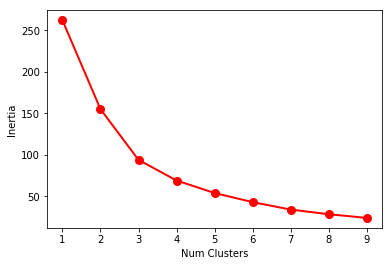

In [48]:
import matplotlib.pyplot as plt
x, y = zip(*[inertia for inertia in inertia_clusters])
plt.plot(x, y, 'ro-', markersize=8, lw=2)
plt.xlabel('Num Clusters')
plt.ylabel('Inertia')
plt.show()


According to the plot, the optimal number of clusters is set in 4

In [37]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(madrid_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 3, 3, 0, 3, 3, 3, 3, 3, 3], dtype=int32)

In [38]:
# add clustering labels

madrid_grouped_sorted=final_df

madrid_grouped_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

madrid_grouped_sorted


,Cluster Labels,Neighbourhood,Borough,Longitude,Latitude,Total_Pets_Neighbourhood,Inc_5_y (%),Number_of_Vets,pets/vet
0,3,PALACIO,CENTRO,-3.711270,40.414430,4055.0,43.7,6.0,676.0
1,3,EMBAJADORES,CENTRO,-3.702885,40.409738,8070.0,43.7,5.0,1614.0
2,3,CORTES,CENTRO,-3.697530,40.414064,1857.0,43.7,3.0,619.0
3,0,JUSTICIA,CENTRO,-3.697507,40.423651,3074.0,43.7,1.0,3074.0
4,3,UNIVERSIDAD,CENTRO,-3.706039,40.425119,5711.0,43.7,5.0,1142.0
5,3,SOL,CENTRO,-3.704920,40.416991,1300.0,43.7,1.0,1300.0
6,3,IMPERIAL,ARGANZUELA,-3.718203,40.407663,2223.0,31.7,3.0,741.0
7,3,ACACIAS,ARGANZUELA,-3.706246,40.401900,3587.0,31.7,7.0,512.0
8,3,CHOPERA,ARGANZUELA,-3.698228,40.395881,1961.0,31.7,3.0,654.0
9,3,LEGAZPI,ARGANZUELA,-3.689785,40.388806,1920.0,31.7,2.0,960.0


In [49]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(madrid_grouped_sorted['Latitude'], madrid_grouped_sorted['Longitude'], madrid_grouped_sorted['Neighbourhood'], madrid_grouped_sorted['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Cluster 0

In [40]:
madrid_cluster_0=madrid_grouped_sorted.loc[madrid_grouped_sorted['Cluster Labels'] == 0, madrid_grouped_sorted.columns[[1] + list(range(5, madrid_grouped_sorted.shape[1]))]]
madrid_cluster_0

,Neighbourhood,Total_Pets_Neighbourhood,Inc_5_y (%),Number_of_Vets,pets/vet
3,JUSTICIA,3074.0,43.7,1.0,3074.0
67,SAN ISIDRO,3966.0,29.7,1.0,3966.0
69,PUERTA BONITA,3555.0,29.7,1.0,3555.0
106,VILLAVERDE ALTO C.H.,4550.0,32.6,0.0,4550.0


In [41]:
madrid_cluster_0.describe()

,Total_Pets_Neighbourhood,Inc_5_y (%),Number_of_Vets,pets/vet
count,4.000000,4.000000,4.00,4.000000
mean,3786.250000,33.925000,0.75,3786.250000
std,626.205704,6.658516,0.50,626.205704
min,3074.000000,29.700000,0.00,3074.000000
25%,3434.750000,29.700000,0.75,3434.750000
50%,3760.500000,31.150000,1.00,3760.500000
75%,4112.000000,35.375000,1.00,4112.000000
max,4550.000000,43.700000,1.00,4550.000000


These 4 neighbourhoods are located in boroughs with a high increase in the number of pets in the last 5 years and with a high ratio pets/vets. The neighbourhoods included in this cluster are preferential to install a new veterinary clinic.

#### Cluster 1

In [42]:
madrid_cluster_1=madrid_grouped_sorted.loc[madrid_grouped_sorted['Cluster Labels'] == 1, madrid_grouped_sorted.columns[[1] + list(range(5, madrid_grouped_sorted.shape[1]))]]
madrid_cluster_1

,Neighbourhood,Total_Pets_Neighbourhood,Inc_5_y (%),Number_of_Vets,pets/vet
13,PACIFICO,3015.0,6.0,9.0,335.0
14,ADELFAS,1680.0,6.0,3.0,560.0
16,IBIZA,1947.0,6.0,3.0,649.0
17,LOS JERONIMOS,626.0,6.0,2.0,313.0
18,NIÑO JESUS,1380.0,6.0,2.0,690.0
19,RECOLETOS,1907.0,21.0,3.0,636.0
20,GOYA,3620.0,21.0,5.0,724.0
21,FUENTE DEL BERRO,2572.0,21.0,4.0,643.0
22,GUINDALERA,5100.0,21.0,13.0,392.0
23,LISTA,2553.0,21.0,4.0,638.0


In [43]:
madrid_cluster_1.describe()

,Total_Pets_Neighbourhood,Inc_5_y (%),Number_of_Vets,pets/vet
count,65.000000,65.000000,65.000000,65.000000
mean,2594.692308,13.269231,3.723077,693.138462
std,1521.523270,5.624026,2.534189,247.629188
min,176.000000,1.900000,0.000000,176.000000
25%,1733.000000,11.400000,2.000000,522.000000
50%,2548.000000,12.200000,4.000000,653.000000
75%,3263.000000,19.100000,5.000000,858.000000
max,7083.000000,21.200000,13.000000,1317.000000


These 65 neighbourhoods are located in boroughs with a low increase in the number of pets in the last 5 years and with very low ratio pets/vets. The neighbourhoods included in this cluster are the worst to install a new veterinary clinic.

#### Cluster 2

In [44]:
madrid_cluster_2=madrid_grouped_sorted.loc[madrid_grouped_sorted['Cluster Labels'] == 2, madrid_grouped_sorted.columns[[1] + list(range(5, madrid_grouped_sorted.shape[1]))]]
madrid_cluster_2

,Neighbourhood,Total_Pets_Neighbourhood,Inc_5_y (%),Number_of_Vets,pets/vet
15,ESTRELLA,2081.0,6.0,1.0,2081.0
24,CASTELLANA,2080.0,21.0,1.0,2080.0
35,VALDEACEDERAS,2843.0,19.1,0.0,2843.0
53,CIUDAD UNIVERSITARIA,2134.0,14.1,1.0,2134.0
62,CAMPAMENTO,2232.0,32.1,1.0,2232.0
64,LAS AGUILAS,5887.0,32.1,3.0,1962.0
73,ORCASUR,1473.0,21.2,1.0,1473.0
74,SAN FERMIN,2514.0,21.2,1.0,2514.0
75,ALMENDRALES,2299.0,21.2,1.0,2299.0
76,MOSCARDO,2831.0,21.2,2.0,1416.0


In [45]:
madrid_cluster_2.describe()

,Total_Pets_Neighbourhood,Inc_5_y (%),Number_of_Vets,pets/vet
count,25.000000,25.000000,25.000000,25.000000
mean,2988.200000,20.612000,1.400000,1962.880000
std,1694.681927,6.135234,0.912871,432.878863
min,1419.000000,6.000000,0.000000,1416.000000
25%,1858.000000,18.800000,1.000000,1653.000000
50%,2232.000000,21.000000,1.000000,1923.000000
75%,3306.000000,21.200000,2.000000,2232.000000
max,7490.000000,32.600000,3.000000,2882.000000


These 25 neighbourhoods are located in boroughs with a low increase in the number of pets in the last 5 years but  with high ratio pets/vets. The neighbourhoods included in this cluster are good location to install a new veterinary clinic yet.

#### Cluster 3

In [46]:
madrid_cluster_3 = madrid_grouped_sorted.loc[madrid_grouped_sorted['Cluster Labels'] == 3, madrid_grouped_sorted.columns[[1] + list(range(5, madrid_grouped_sorted.shape[1]))]]
madrid_cluster_3

,Neighbourhood,Total_Pets_Neighbourhood,Inc_5_y (%),Number_of_Vets,pets/vet
0,PALACIO,4055.0,43.7,6.0,676.0
1,EMBAJADORES,8070.0,43.7,5.0,1614.0
2,CORTES,1857.0,43.7,3.0,619.0
4,UNIVERSIDAD,5711.0,43.7,5.0,1142.0
5,SOL,1300.0,43.7,1.0,1300.0
6,IMPERIAL,2223.0,31.7,3.0,741.0
7,ACACIAS,3587.0,31.7,7.0,512.0
8,CHOPERA,1961.0,31.7,3.0,654.0
9,LEGAZPI,1920.0,31.7,2.0,960.0
10,DELICIAS,2733.0,31.7,2.0,1366.0


In [47]:
madrid_cluster_3.describe()

,Total_Pets_Neighbourhood,Inc_5_y (%),Number_of_Vets,pets/vet
count,37.000000,37.000000,37.000000,37.000000
mean,3013.972973,34.045946,3.189189,952.270270
std,1833.767683,7.651782,2.258783,396.125447
min,116.000000,25.700000,0.000000,116.000000
25%,1655.000000,29.700000,2.000000,676.000000
50%,2733.000000,31.700000,3.000000,953.000000
75%,4055.000000,32.600000,5.000000,1142.000000
max,8070.000000,53.200000,9.000000,1655.000000


These 37 neighbourhoods are located in boroughs with a high increase in the number of pets in the last 5 years but  with a low ratio pets/vets. The neighbourhoods included in this cluster are not good location to install a new veterinary clinic at the present but can be studied at the future to see how the increase evolves.